In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Stochastic Environment

## Pricing

In [35]:
np.random.seed(42)

In [36]:
# params
conversion_probability = lambda p: 1-p/1
# T = 500
T = 1
# n_customers = 100
n_customers = 1
cost = 0.3

In [37]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t

In [38]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)

    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [39]:
# this is the blueprint of an Agent-type class, we can customize this with our strategy
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass

In [40]:
class GPUCBAgent(Agent):
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0

    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms)
        ucbs = self.mu_t + self.beta(t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

In [41]:
reward_function = lambda price, n_sales: (price-cost)*n_sales

min_price, max_price = 0, 1
agent = GPUCBAgent(T)
np.random.seed(2)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

prices = np.linspace(min_price, max_price, 1000)
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    d_t, r_t = env.round(p_t, n_t=n_customers)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

In [42]:
prices = agent.action_hist
profits = agent.reward_hist

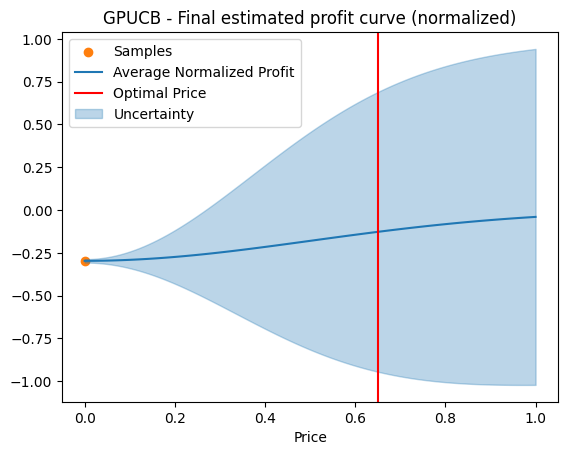

In [43]:
gp = RBFGaussianProcess(scale=2)
gp.fit(prices, profits)
mu, sigma = gp.predict(np.linspace(0,1,100))
plt.scatter(prices, profits, label='Samples', color='C1')
plt.plot(np.linspace(0,1,100), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(0,1,100), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show()

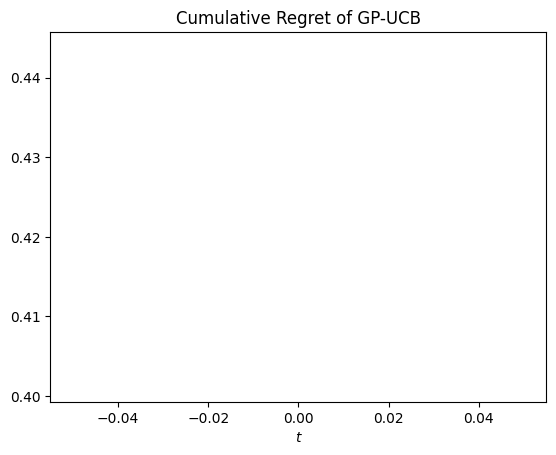

In [44]:
plt.figure()
plt.plot(cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show()

## Bidding

### Setup

In [45]:
n_adv = 4 # excluding us
T = 30_000 # number of rounds
budget = 1_000
K = 11
valuation = 0.7
lambda_s = 0.9 # for all advertisers
q_s = 0.9 # for all advertisers
bids_mean = [0.1, 0.2, 0.3, 0.2]
bids_std = [0.01, 0.01, 0.01, 0.01]

In [46]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [47]:
class SecondPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)

### Clairvoyant definition

In [48]:
### As a reusable function:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

In [49]:
def generate_bids(T, bids_mean, bids_std):

  n_avd = len(bids_mean)

  bids = np.zeros((n_adv, T))

  for i in range(n_adv):
      bids[i] = np.random.normal(bids_mean[i], bids_std[i], T)

  return np.clip(bids, 0, 1)

### Primal-dual (FF Pacing Strategy) - Bandit feedback

In [50]:
class EXP3Agent(Agent):
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.weights = self.weights / np.max(self.weights) #avoid overflow caused by high learning rate
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t, armIndex):
        l_tilde = l_t / self.x_t[armIndex]
        self.weights[armIndex] *= np.exp(-self.learning_rate*l_tilde)
        self.t += 1

In [51]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.lmbdHist = []
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.exp3 = EXP3Agent(self.K, 50*np.sqrt(np.log(self.K)/T)) # from theory it should be np.sqrt(np.log(self.K)/T)
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.exp3.pull_arm()]

    def update(self, f_t, c_t, my_bid):
        # update exp3
        L = f_t - self.lmbd*(c_t-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        my_bid_index = np.where(self.bids_set == my_bid)[0]
        self.exp3.update((2-L)/range_L, my_bid_index) # exp3 needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.lmbdHist.append(self.lmbd)
        # update budget
        self.budget -= c_t

In [52]:
n_trials = 2
starting_seed = 0
eta = 50/np.sqrt(T) # from theory it should be 1/np.sqrt(T)
available_bids = np.linspace(0, 1, K) # discretizing the set of prices (arms)

In [53]:
my_arm_probabilities = []
my_bids = []
my_cum_payments = []
my_regret = []

for trial in range(n_trials):

  np.random.seed(trial + starting_seed)

  auction = SecondPriceAuction(np.ones(n_adv+1))

  agent = FFMultiplicativePacingAgent(bids_set = available_bids,
                                    valuation=valuation,
                                    budget=budget,
                                    T=T,
                                    eta=eta)

  bids = generate_bids(T, bids_mean, bids_std)
  maxBid = np.max(bids, axis=0)

  my_bids_per_trial = np.array([])
  my_payments_per_trial = np.array([])
  my_regret_per_trial = []

  clairvoyant = get_clairvoyant_truthful(budget, valuation, maxBid, T)
  clairvoyant_rewards = clairvoyant[1]
  utilities_per_trial = np.array([])
  total_wins = 0

  for u in range(T):
      # interaction
      my_bid = agent.bid()
      allBids = np.array(my_bid)
      allBids = np.append(allBids, bids[:,u])
      winners, payments_per_click = auction.round(bids=allBids)
      my_win = int(winners==0)
      f_t, c_t = (valuation-maxBid[u])*my_win, maxBid[u]*my_win
      agent.update(f_t, c_t, my_bid)

      # logging
      utilities_per_trial = np.append(utilities_per_trial, f_t)
      my_bids_per_trial = np.append(my_bids_per_trial, my_bid)
      my_payments_per_trial = np.append(my_payments_per_trial, c_t)
      total_wins += my_win

  cum_payments = np.cumsum(my_payments_per_trial)
  my_regret_per_trial = np.cumsum(clairvoyant_rewards-utilities_per_trial)

  print(f"Trial {trial}")
  print("------------------------")
  print(f'Total agent wins: {total_wins}')
  print(f"Total clairvoyant expenses {clairvoyant[2].sum():0.3f}:")
  print(f"Total agent expenses {budget-agent.budget:0.3f}")
  print("========================")

  my_arm_probabilities.append(agent.exp3.x_t)
  my_bids.append(my_bids_per_trial)
  my_cum_payments.append(cum_payments)
  my_regret.append(my_regret_per_trial)

Trial 0
------------------------
Total agent wins: 3340
Total clairvoyant expenses 999.242:
Total agent expenses 999.228
Trial 1
------------------------
Total agent wins: 3344
Total clairvoyant expenses 999.016:
Total agent expenses 999.084


In [54]:
my_arm_probabilities = np.array(my_arm_probabilities)
my_bids = np.array(my_bids_per_trial)
my_cum_payments = np.array(my_cum_payments)
my_regret = np.array(my_regret)

In [55]:
my_arm_probabilities_mean = np.mean(my_arm_probabilities, axis=0)
my_arm_probabilities_std = np.std(my_arm_probabilities, axis=0)

my_bids_avg = np.mean(my_bids, axis=0)
my_bids_std = np.std(my_bids, axis=0)

my_cum_payments_avg = np.mean(my_cum_payments, axis=0)
my_cum_payments_std = np.std(my_cum_payments, axis=0)

my_regret_avg = np.mean(my_regret, axis=0)
my_regret_std = np.std(my_regret, axis=0)

a = my_regret_avg

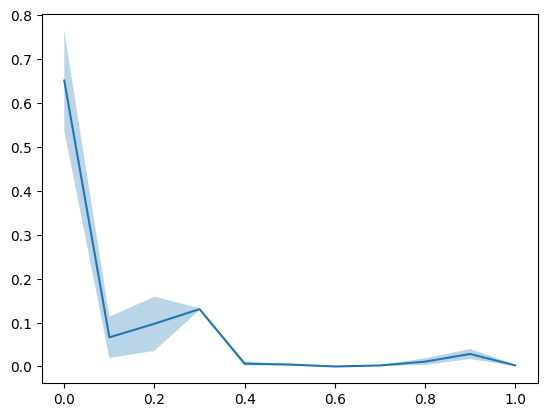

In [56]:
plt.plot(available_bids, my_arm_probabilities_mean)
plt.fill_between(available_bids,
                my_arm_probabilities_mean - my_arm_probabilities_std/np.sqrt(n_trials),
                my_arm_probabilities_mean + my_arm_probabilities_std/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')

Text(0.5, 1.0, 'Cumulative Regret of Multiplicative Pacing')

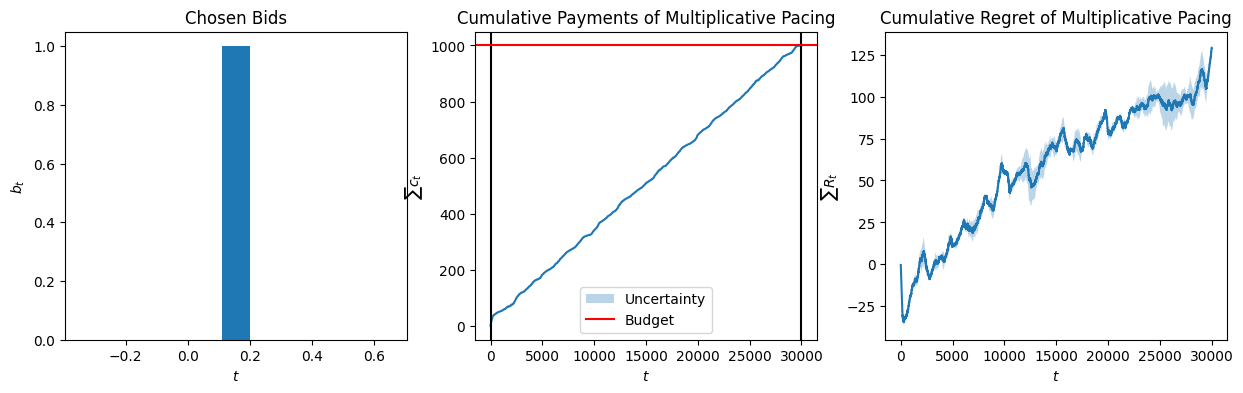

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axs = axs.ravel()

axs[0].hist(my_bids_avg, bins=K)
# Find out how to plot std of bins
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$b_t$')
axs[0].set_title('Chosen Bids')

axs[1].plot(my_cum_payments_avg)
axs[1].fill_between(np.arange(T),
                my_cum_payments_avg - my_cum_payments_std/np.sqrt(n_trials),
                my_cum_payments_avg + my_cum_payments_std/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
axs[1].axvline(0, color="black")
axs[1].axvline(T, color="black")
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum c_t$')
axs[1].axhline(budget, color='red', label='Budget')
axs[1].legend()
axs[1].set_title('Cumulative Payments of Multiplicative Pacing')

axs[2].plot(my_regret_avg)
axs[2].fill_between(np.arange(T),
                my_regret_avg - my_regret_std/np.sqrt(n_trials),
                my_regret_avg + my_regret_std/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Multiplicative Pacing')

### Primal-dual (SP Pacing Strategy)

In [58]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)

    def update(self, f_t, c_t, m_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [59]:
my_bids = []
my_cum_payments = []
my_regret = []

for trial in range(n_trials):

  np.random.seed(trial)

  auction = SecondPriceAuction(np.ones(n_adv+1))

  agent = MultiplicativePacingAgent(valuation=valuation,
                                    budget=budget,
                                    T=T,
                                    eta=eta)

  bids = generate_bids(T, bids_mean, bids_std)
  maxBid = np.max(bids, axis=0)

  my_bids_per_trial = np.array([])
  my_payments_per_trial = np.array([])
  my_regret_per_trial = []

  clairvoyant = get_clairvoyant_truthful(budget, valuation, maxBid, T)
  clairvoyant_rewards = clairvoyant[1]
  utilities_per_trial = np.array([])
  total_wins = 0

  for u in range(T):
      # interaction
      my_bid = agent.bid()
      allBids = np.array(my_bid)
      allBids = np.append(allBids, bids[:,u])
      winners, payments_per_click = auction.round(bids=allBids)
      my_win = int(winners==0)
      f_t, c_t = (valuation-maxBid[u])*my_win, maxBid[u]*my_win
      agent.update(f_t, c_t, maxBid[u])

      # logging
      utilities_per_trial = np.append(utilities_per_trial, f_t)
      my_bids_per_trial = np.append(my_bids_per_trial, my_bid)
      my_payments_per_trial = np.append(my_payments_per_trial, c_t)
      total_wins += my_win

  cum_payments = np.cumsum(my_payments_per_trial)
  my_regret_per_trial = np.cumsum(clairvoyant_rewards-utilities_per_trial)

  print(f"Trial {trial}")
  print("------------------------")
  print(f'Total agent wins: {total_wins}')
  print(f"Total clairvoyant expenses {clairvoyant[2].sum():0.3f}:")
  print(f"Total agent expenses {budget-agent.budget:0.3f}")
  print("========================")

  my_bids.append(my_bids_per_trial)
  my_cum_payments.append(cum_payments)
  my_regret.append(my_regret_per_trial)

Trial 0
------------------------
Total agent wins: 3503
Total clairvoyant expenses 999.242:
Total agent expenses 999.267
Trial 1
------------------------
Total agent wins: 3502
Total clairvoyant expenses 999.016:
Total agent expenses 999.122


In [60]:
my_bids = np.array(my_bids_per_trial)
my_cum_payments = np.array(my_cum_payments)
my_regret = np.array(my_regret)

In [61]:
my_bids_avg = np.mean(my_bids, axis=0)
my_bids_std = np.std(my_bids, axis=0)

my_cum_payments_avg = np.mean(my_cum_payments, axis=0)
my_cum_payments_std = np.std(my_cum_payments, axis=0)

my_regret_avg = np.mean(my_regret, axis=0)
my_regret_std = np.std(my_regret, axis=0)

b = my_regret_avg

Text(0.5, 1.0, 'Cumulative Regret of Multiplicative Pacing')

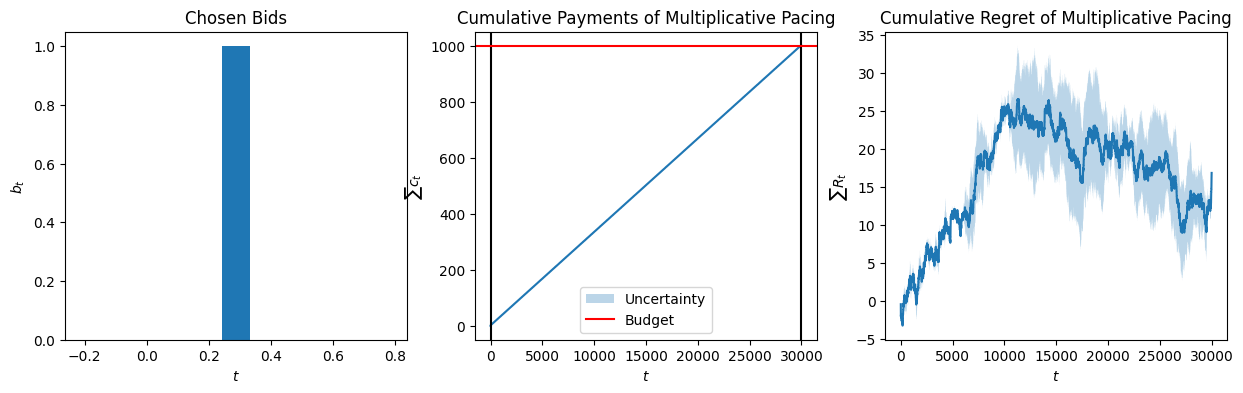

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axs = axs.ravel()

axs[0].hist(my_bids_avg, bins=K)
# Find out how to plot std of bins
axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$b_t$')
axs[0].set_title('Chosen Bids')

axs[1].plot(my_cum_payments_avg)
axs[1].fill_between(np.arange(T),
                my_cum_payments_avg - my_cum_payments_std/np.sqrt(n_trials),
                my_cum_payments_avg + my_cum_payments_std/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
axs[1].axvline(0, color="black")
axs[1].axvline(T, color="black")
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\sum c_t$')
axs[1].axhline(budget, color='red', label='Budget')
axs[1].legend()
axs[1].set_title('Cumulative Payments of Multiplicative Pacing')

axs[2].plot(my_regret_avg)
axs[2].fill_between(np.arange(T),
                my_regret_avg - my_regret_std/np.sqrt(n_trials),
                my_regret_avg + my_regret_std/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$\sum R_t$')
axs[2].set_title('Cumulative Regret of Multiplicative Pacing')

### UCB1

# Requirement 3: two extensions for pricing

1) make sure the imports are correct

In [63]:
### 2. Define the Environment
# We will create a class `NonStationaryEnvironment` that simulates the demand over different intervals.
# Each interval will have a different linear demand curve defined by its own parameters.

class NonStationaryEnvironment:
    def __init__(self, intervals, slopes, intercepts, num_steps, noise_type='normal', noise_params=None):
        """
        Initializes the non-stationary environment.

        Parameters:
        - intervals: List of tuples indicating the start and end day of each interval.
        - slopes: List of slopes for the demand curves in each interval.
        - intercepts: List of intercepts for the demand curves in each interval.
        - num_steps: Number of discrete steps for prices in the range [0, 1].
        - noise_type: Type of noise ('normal' or 'uniform').
        - noise_params: Parameters for the noise distribution.
        """
        self.intervals = intervals
        self.slopes = slopes
        self.intercepts = intercepts
        self.num_steps = num_steps
        self.discrete_steps = np.linspace(0, 1, num_steps)
        self.noise_type = noise_type
        self.noise_params = noise_params or {}

    def get_noise(self):
        """
        Generates noise based on the specified noise type and parameters.

        Returns:
        - noise: Generated noise value.
        """
        if self.noise_type == 'normal':
            mean = self.noise_params.get('mean', 0)
            std = self.noise_params.get('std', 1)
            noise = np.random.normal(mean, std)
        elif self.noise_type == 'uniform':
            low = self.noise_params.get('low', -1)
            high = self.noise_params.get('high', 1)
            noise = np.random.uniform(low, high)
        else:
            raise ValueError(f"Unsupported noise type: {self.noise_type}")
        return noise

    def get_demand(self, day):
        """
        Returns the demand for each price in the range [0, 1] for a given day.

        Parameters:
        - day: The day for which the demand is requested.

        Returns:
        - demands: Array of demands for each price in the discretized range [0, 1].
        """
        for (start, end), slope, intercept in zip(self.intervals, self.slopes, self.intercepts):
            if start <= day <= end:
                demands = slope * self.discrete_steps + intercept
                demands = np.maximum(demands + self.get_noise(), 0)  # Ensure non-negative demand
                return demands
        return np.zeros(len(self.discrete_steps))  # Default demand if day is out of intervals

    def simulate(self, days):
        """
        Simulates the demand over a range of days.

        Parameters:
        - days: List or array of days to simulate.

        Returns:
        - demands: Matrix of simulated demands for each price step over the days.
        """
        demands_matrix = np.zeros((len(days), self.num_steps))
        for i, day in enumerate(days):
            demands_matrix[i, :] = self.get_demand(day)
        return demands_matrix

In [64]:
### 3. Define Simulation Parameters
# Next, we define the intervals, slopes, and intercepts for the demand curves, and simulate the environment.

# Define intervals (start day, end day)
intervals = [(0, 30), (31, 60), (61, 90)]

# Define slopes and intercepts for each interval
slopes = [-2, -1.5, -3]      # Example slopes for demand curves
intercepts = [100, 80, 120]  # Example intercepts for demand curves

# Define noise parameters
noise_type = 'normal'  # Change to 'uniform' if needed
noise_params = {'mean': 0, 'std': 5}  # Parameters for normal noise

# Define number of discrete steps
num_steps = 10

# Initialize environment with custom noise and discretization
env = NonStationaryEnvironment(intervals, slopes, intercepts, num_steps, noise_type, noise_params)

# Simulate days
days = np.arange(0, 91)

# Get simulated demands
demands_matrix = env.simulate(days)

# Create a DataFrame for visualization
data = pd.DataFrame(demands_matrix, columns=[f'Price {i}' for i in range(num_steps)])
data['Day'] = days

# first few rows of the DataFrame print
data.head()

,Price 0,Price 1,Price 2,Price 3,Price 4,Price 5,Price 6,Price 7,Price 8,Price 9,Day
0,106.236482,106.014260,105.792038,105.569815,105.347593,105.125371,104.903149,104.680927,104.458704,104.236482,0
1,100.911967,100.689744,100.467522,100.245300,100.023078,99.800855,99.578633,99.356411,99.134189,98.911967,1
2,101.275643,101.053421,100.831199,100.608976,100.386754,100.164532,99.942310,99.720087,99.497865,99.275643,2
3,101.061483,100.839261,100.617038,100.394816,100.172594,99.950372,99.728150,99.505927,99.283705,99.061483,3
4,89.198326,88.976103,88.753881,88.531659,88.309437,88.087215,87.864992,87.642770,87.420548,87.198326,4


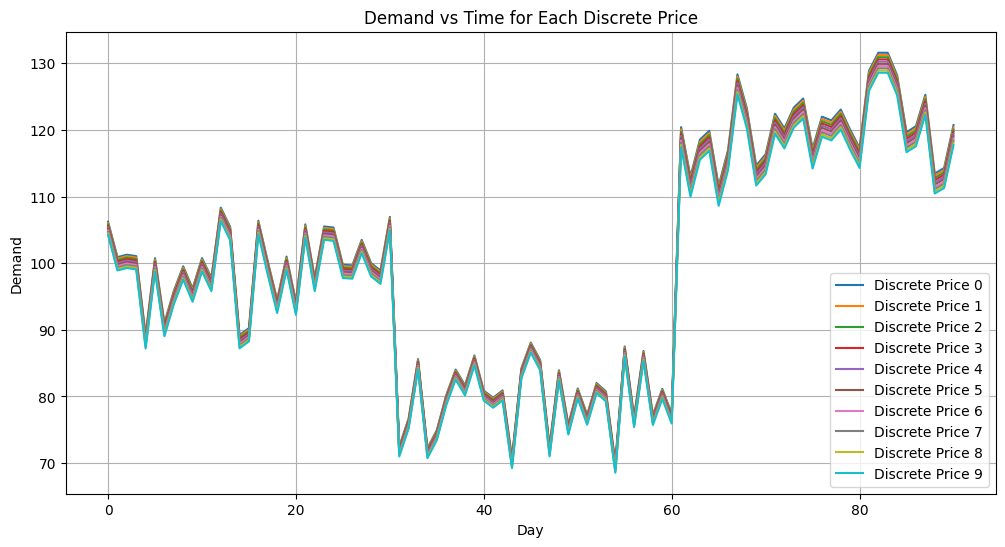

In [68]:
### 4. Visualize the Simulation
# visualize the simulated demand over the days.

# Plot demand vs time for each discrete price
plt.figure(figsize=(12, 6))

for i in range(num_steps):
    plt.plot(days, demands_matrix[:, i], label=f'Discrete Price {i}')

plt.xlabel('Day')
plt.ylabel('Demand')
plt.title('Demand vs Time for Each Discrete Price')
plt.legend()
plt.grid(True)
plt.show()

